# **Denoising Diffusion Probabilistic Models with MiniAi - Part 2**

In [1]:
import pickle,gzip,math,os,time,shutil,random,logging
import fastcore.all as fc
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [2]:
import warnings

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)
warnings.filterwarnings('ignore')

## **Load Dataset and Test `noisify()`**

In [3]:
xl, yl = 'image', 'label'
name = "fashion_mnist"
dsd = load_dataset(name)

# We won't be converting to 32x32 this time around
# instead, all image tensors will have a default padding
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2, 2, 2, 2)) for o in b[xl]]

bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [4]:
# Setup training dl and batches 
dt = dls.train
xb, yb = next(iter(dt))

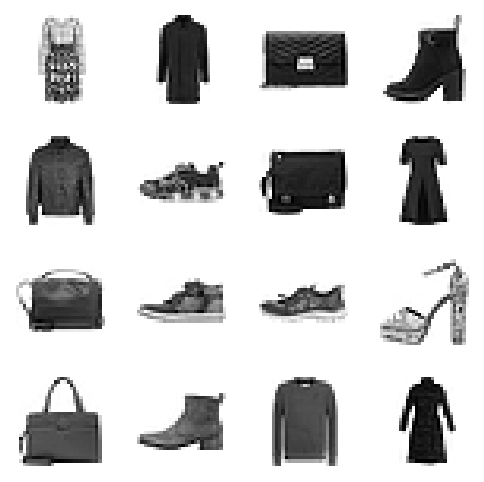

In [5]:
show_images(xb[:16], imsize=1.5)

In [6]:
betamin, betamax, n_steps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1. - beta
alpha_bar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

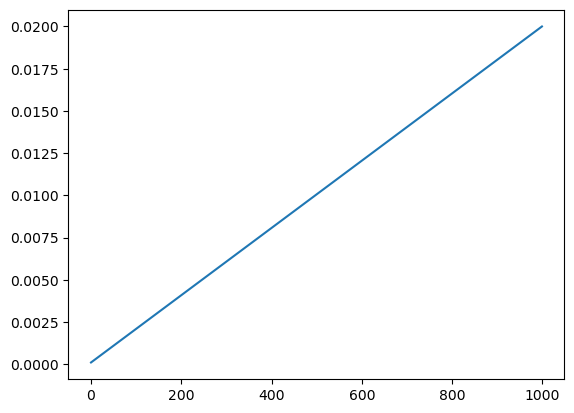

In [7]:
plt.plot(beta);

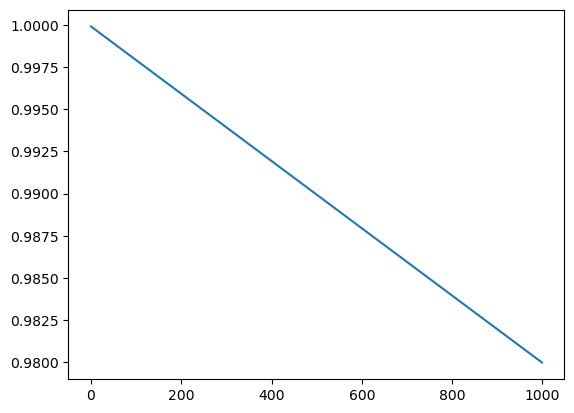

In [8]:
plt.plot(alpha);

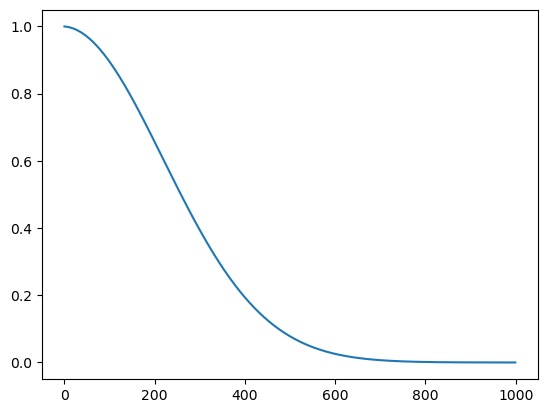

In [9]:
plt.plot(alpha_bar);

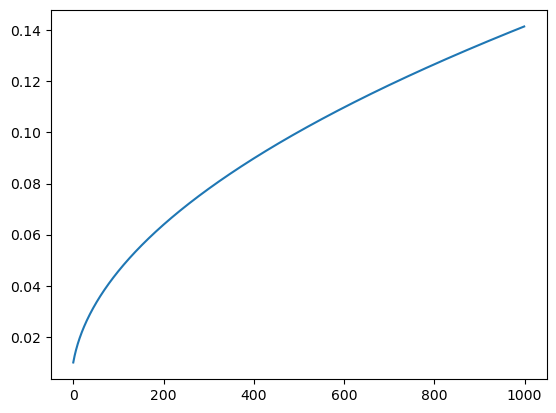

In [10]:
plt.plot(sigma);

Here, we are extracting the bits of code from the previous NB in the series which add noise to our inputs and shall proceed to call it `noisify()`

In [11]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

Experimenting with using `noisify()` with 25 images, each with a random noise timestep `t`. We can print the individual timesteps are titles for the image grid.

In [12]:
(xt, t), ε = noisify(xb[:25], alpha_bar)
t

tensor([367, 520, 517, 528, 906, 286, 404, 972, 759, 950,  31, 933, 379, 142,
        173, 311, 577, 958, 357,  20,  56, 585, 976, 672, 835])

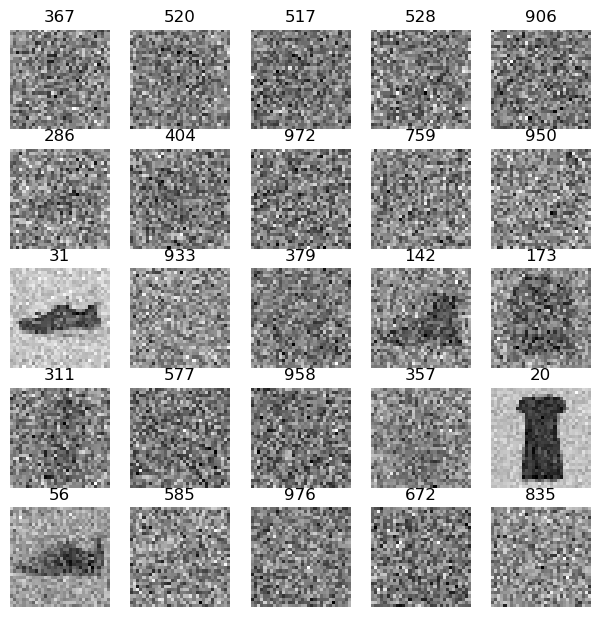

In [13]:
titles = fc.map_ex(t, '{}')
show_images(xt, imsize=1.5, titles=titles)

## **Training**

In [14]:
from diffusers import UNet2DModel

In [15]:
@torch.no_grad()
def sample(model, sz, alpha, alpha_bar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)): # Return a reversed iterator
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t>0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alpha_bar[t-1] if t>0 else torch.tensor(1)
        b̄_t = 1 - alpha_bar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * learn.model((x_t, t_batch))) / alpha_bar[t].sqrt()).clamp(-1, 1)
        x_t = x_0_hat * ᾱ_t1.sqrt() * (1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu())
    return preds

In [38]:
# The Callback has fewer lines of code since we extracted noisify as a separate function.
# The key difference here is that we are inheriting from the Callback class and not TrainCB.
# So, we won't be using the predict() function here.
class DDPMCB(Callback):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.α = 1. - self.beta 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.beta.sqrt()
    
    def before_batch(self, learn): learn.batch = noisify(learn.batch[0], self.ᾱ)

    def sample(self, model, sz): return sample(model, sz, self.α, self.ᾱ, self.σ, self.n_steps)

The MiniAi framework allows us the flexibility to replace models, their components and interfaces, with our own versions. 

In [39]:
# In the previous NB predict() was passing ((xt, t),ε) to the model which then return the sample.
# Here we can inherit from the UNet2DModel class to pass in the model, specifically the forward()
# function.
class UNet(UNet2DModel):
    # Calling the original forward() function, and passing it *x instead of x
    # and return sample
    def forward(self, x): return super().forward(*x).sample

In [18]:
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)

We will now use the new `UNet` class to create a model instance. To speed things up, we will also be dividing the channels by 2 to reduce their size. This doesn't appear to have a major impact on the model's ouputs.

Since the model uses group norm, `norm_num_groups` allows us to specify the number of groups to normalize.

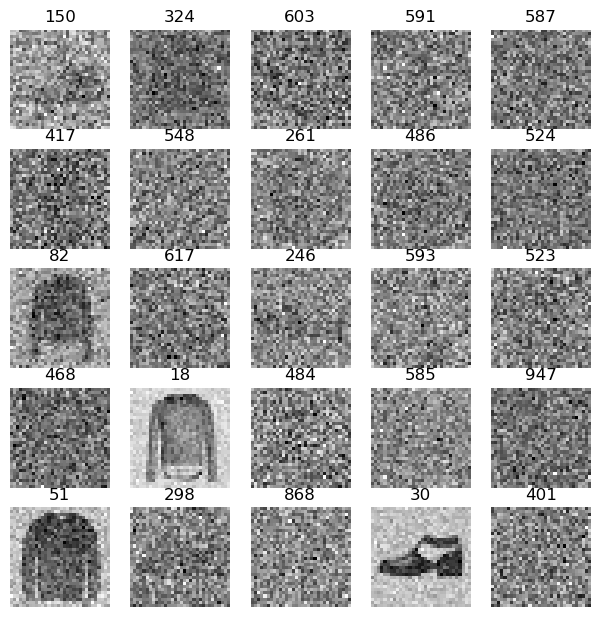

In [19]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

learn = TrainLearner(model, dls, nn.MSELoss())
learn.fit(train=False, cbs=[ddpm_cb, SingleBatchCB()])

(xt, t), ε = learn.batch
show_images(xt[:25], titles=fc.map_ex(t[:25], '{}'), imsize=1.5)

In [20]:
lr = 5e-3
epochs = 5

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

In [21]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)

We need to be able to use higher learning rates. But before we can do that, it is important to note that - at least at the time this NB was being written - the Diffusers library doesn't implement initializations. `init_ddpm()` will allow us to flexibly initalize elements of the ResNet blocks.

In [40]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            # Take every second convolutional layer and zero it out.
            # This makes sure the non-id path of resnets do nothing at first so they don't
            # cause problems later on.
            p.conv2.weight.data.zero_()
            # Refer to orthogonal inits for the weights this time around.
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        # Repeat the above for the up blocks as well.
        for p in o.resnets: p.conv2.weight.data.zero_()
    # Zero out the weights of the last layer.
    model.conv_out.weight.data.zero_()

In [23]:
init_ddpm(model)

In [41]:
# Replace default epsilon with a larger value. This should be a frequent test.
opt_func = partial(optim.Adam, eps=1e-5) 

In [25]:
learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.148,0,train
0.025,0,eval
0.023,1,train
0.021,1,eval
0.020,2,train
0.019,2,eval
0.019,3,train
0.018,3,eval
0.018,4,train
0.018,4,eval


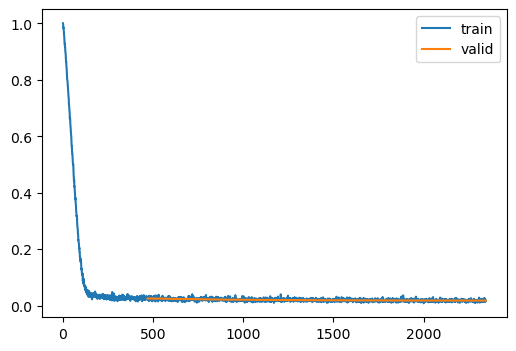

In [26]:
learn.fit(epochs)

### **Sampling**

In [27]:
samples = ddpm_cb.sample(learn.model, (16, 1, 32,32))

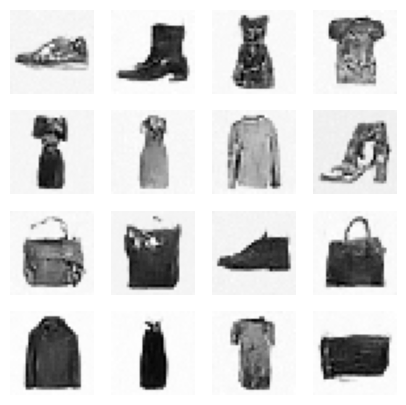

In [28]:
show_images(samples[-1], figsize=(5,5))

### **Mixed Precision**

In [29]:
bs = 512

In [30]:
next(iter(DataLoader(tds['train'], batch_size=2)))

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'label': tensor([9, 0])}

In [31]:
def collate_ddpm(b): return noisify(default_collate(b)[xl], alpha_bar)

def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=8)

In [32]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

Taking advantage of Mixed Precision to speed up the model's training. We will replace default 32 bit fp values (single precision) with 16 bit fp values in a selective manner.

In [33]:
class MixedPrecision(TrainCB):
    order = DeviceCB.order+10

    def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()

    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=torch.float16)
        self.autocast.__enter__()

    def after_loss(self, learn): self.autocast.__exit__(None, None, None)

    def backward(self, learn): self.scaler.scale(learn.loss).backward()

    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

In [34]:
lr = 1e-2
epochs = 10
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)

learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.284,0,train
0.033,0,eval
0.028,1,train
0.029,1,eval
0.025,2,train
0.024,2,eval
0.022,3,train
0.023,3,eval
0.021,4,train
0.021,4,eval


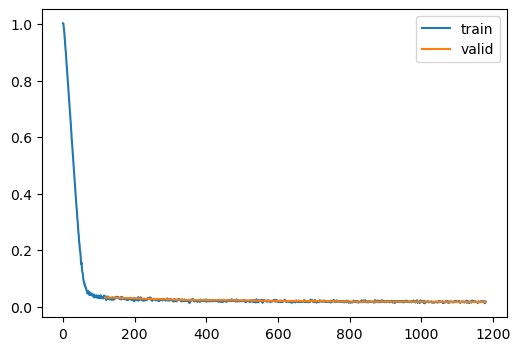

In [35]:
learn.fit(epochs)

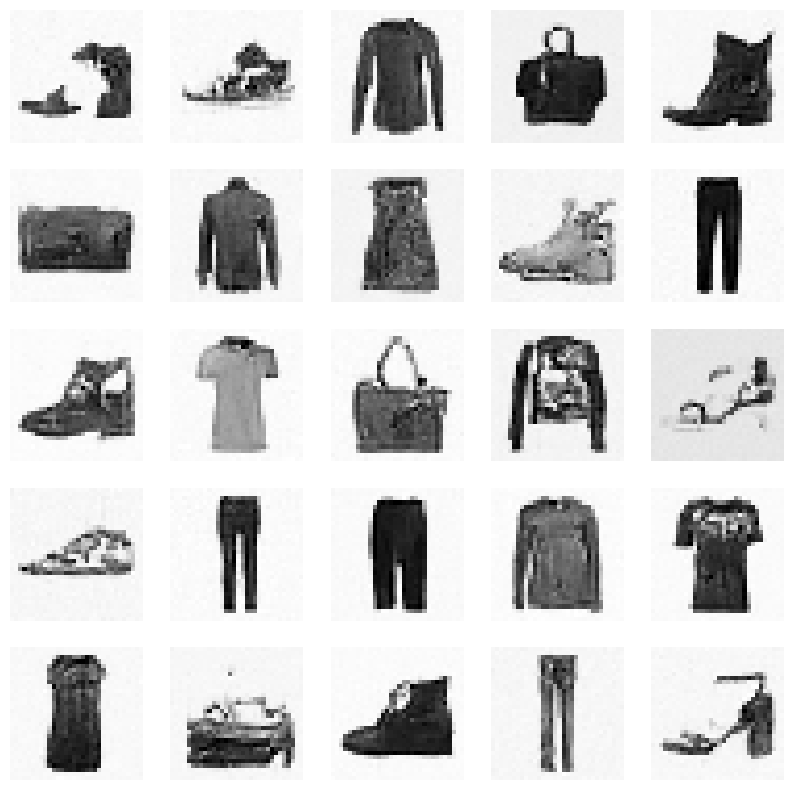

In [36]:
samples = sample(learn.model, (32, 1, 32, 32), alpha, alpha_bar, sigma, n_steps)
show_images(samples[-1][:25], imsize=2)

In [37]:
torch.save(learn.model, 'models/fashion_ddpm_mp.pkl')